# Приоритезация гипотез и оценка результатов A/B-теста. Интернет магазин. 

Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки. Задача: приоритизировать гипотезы, запустить A/B-тест, проанализировать результаты и сделать выводы.

Задача состоит из двух крупных этапов:

1. Произведем приоритезацию выдвинутых гипотез применив метод ICE и RICE.
2. Проверить результаты полученные в ходе A/B теста с целью определить дальнешие действия по тесту:
    - Остановить тест, зафиксировать победу одной из групп.
    - Остановить тест, зафиксировать отсутствие различий между группами.
    - Продолжить тест.
    
Проверку A/B теста будем производить путем построение графиков, отображающих кумулятивные показатели по выручке, количеству заказов, среднего чека, среднего количества заказов на посетителя с целью изучения тенденций, поиска закономерностей и аномалий, а вторым этапом будем считать статистическую значимость по среднему количеству заказов и среднему чеку по:
1. Не очищенным данным
2. По очищенным данным

**Описание полученных данных:**
    
1. Файл hypothesis.csv
    - Hypothesis — краткое описание гипотезы;
    - Reach — охват пользователей по 10-балльной шкале;
    - Impact — влияние на пользователей по 10-балльной шкале;
    - Confidence — уверенность в гипотезе по 10-балльной шкале;
    - Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.


2. Файл orders.csv
    - transactionId — идентификатор заказа;
    - visitorId — идентификатор пользователя, совершившего заказ;
    - date — дата, когда был совершён заказ;
    - revenue — выручка заказа;
    - group — группа A/B-теста, в которую попал заказ.


3. Файл visitors.csv
    - date — дата;
    - group — группа A/B-теста;
    - visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Общая часть

Произведем импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st

Установим максимальную ширину столбцов

In [2]:
pd.options.display.max_colwidth = 160

Напишем общую функцию для получение основной информации о данных

In [3]:
def data_research(data, sample_size=15):
    print('\nData sample, size:', sample_size)
    display(data.sample(sample_size, random_state=1000))
    print('\nData info\n')
    display(data.info())
    print('\nDisplay columns with missing data (as a proportion)\n')
    display(data.isna().mean().where(lambda x: x !=
            0).dropna().sort_values(ascending=False))
    print('\nData describe')
    display(data.describe(include='all'))
    print('\nCheck the number of full duplicate row')
    display(data.duplicated().sum())
    print('\nDisplay common hist')
    for column in data.columns:
        if np.issubdtype(data[column].dtype, np.number):
            data[column].plot(kind='hist', figsize=(10, 5),
                              legend=False, title=column, grid=True)
            plt.show()
    return

## Приоритизация гипотез.
### Загрузка данных и подготовка их к анализу

Получим данные из файлов

In [4]:
try:  
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')  
except:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')

**Изучим полученный файл `hypothesis`**

In [5]:
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Структура файла:

1. Hypothesis — краткое описание гипотезы;
2. Reach — охват пользователей по 10-балльной шкале;
3. Impact — влияние на пользователей по 10-балльной шкале;
4. Confidence — уверенность в гипотезе по 10-балльной шкале;
5. Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

**Изучим полученный файл `orders`**


Data sample, size: 15


,transactionId,visitorId,date,revenue,group
658,1988035100,1016890234,2019-08-26,17990,B
572,4084175636,2430786771,2019-08-04,1990,A
289,1651482177,2147998719,2019-08-02,2210,A
525,3031564664,393266494,2019-08-19,21550,A
42,459882198,1494664757,2019-08-15,9290,B
300,630178370,2845785181,2019-08-18,2342,A
909,1062393,2661240577,2019-08-05,6420,A
397,2956594374,3260527149,2019-08-28,690,B
813,1605437540,3012531415,2019-08-21,6242,A
239,3083858710,3469608676,2019-08-02,10590,A



Data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None


Display columns with missing data (as a proportion)



Series([], dtype: float64)


Data describe


,transactionId,visitorId,date,revenue,group
count,1.197000e+03,1.197000e+03,1197,1.197000e+03,1197
unique,NaN,NaN,31,NaN,2
top,NaN,NaN,2019-08-05,NaN,B
freq,NaN,NaN,48,NaN,640
mean,2.155621e+09,2.165960e+09,NaN,8.348006e+03,NaN
std,1.229085e+09,1.236014e+09,NaN,3.919113e+04,NaN
min,1.062393e+06,5.114589e+06,NaN,5.000000e+01,NaN
25%,1.166776e+09,1.111826e+09,NaN,1.220000e+03,NaN
50%,2.145194e+09,2.217985e+09,NaN,2.978000e+03,NaN
75%,3.237740e+09,3.177606e+09,NaN,8.290000e+03,NaN



Check the number of full duplicate row


0


Display common hist


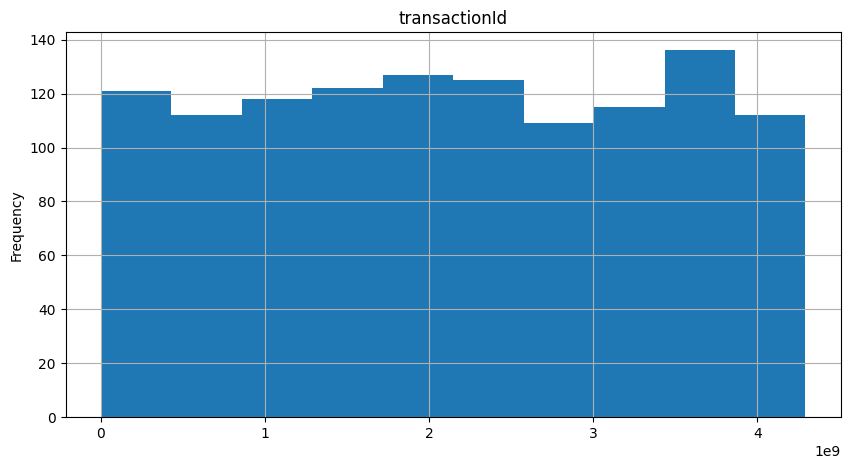

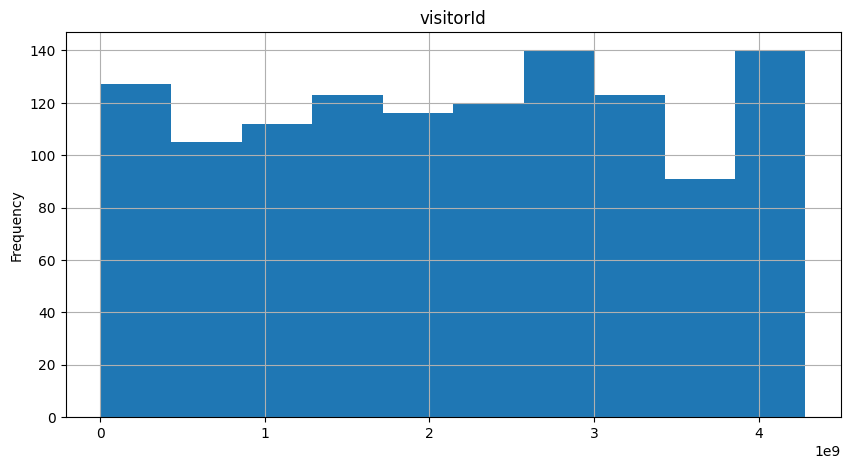

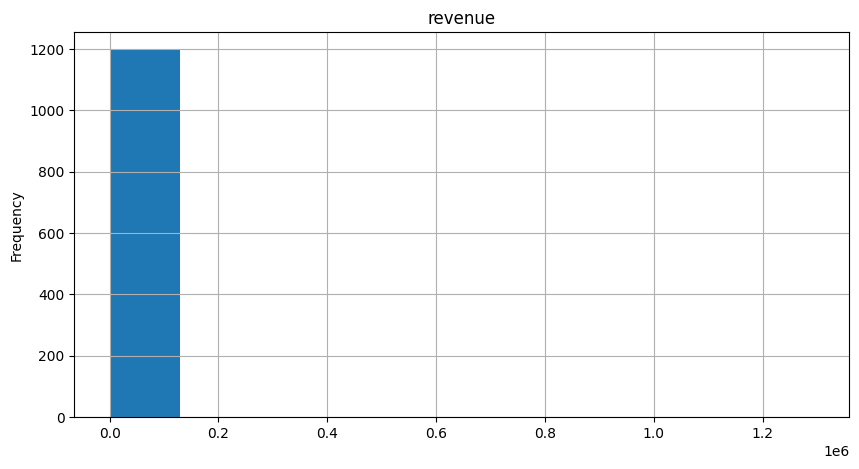

In [6]:
data_research(orders)

Структура файла:

1. transactionId — идентификатор заказа;
2. visitorId — идентификатор пользователя, совершившего заказ;
3. date — дата, когда был совершён заказ;
4. revenue — выручка заказа;
5. group — группа A/B-теста, в которую попал заказ.


По гистограмме частоты столбца `revenue` видно, что есть выбросы, рассмотрим их подробнее с помощью **boxplot**, в разрезе групп тестирования.

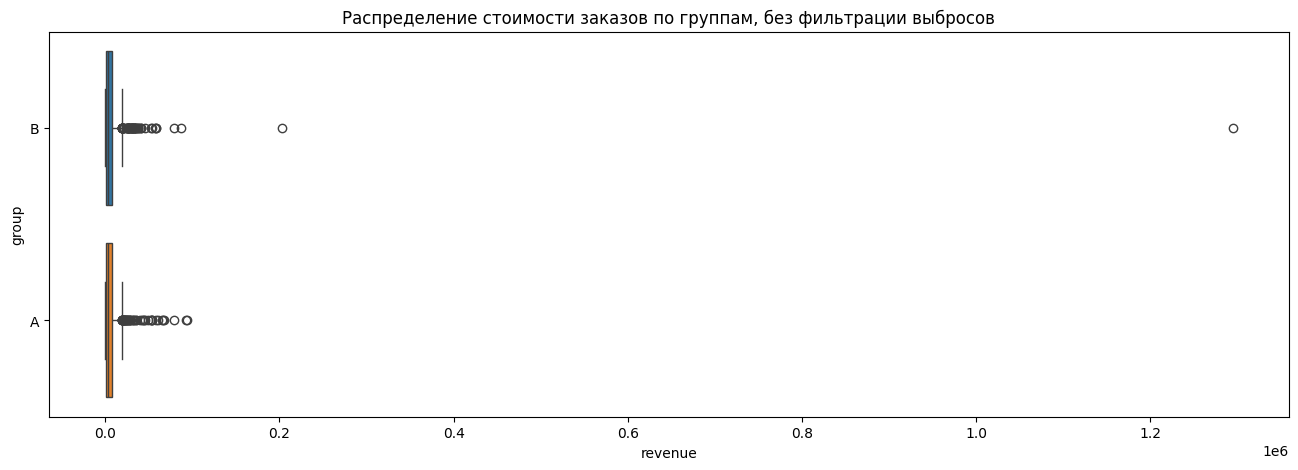

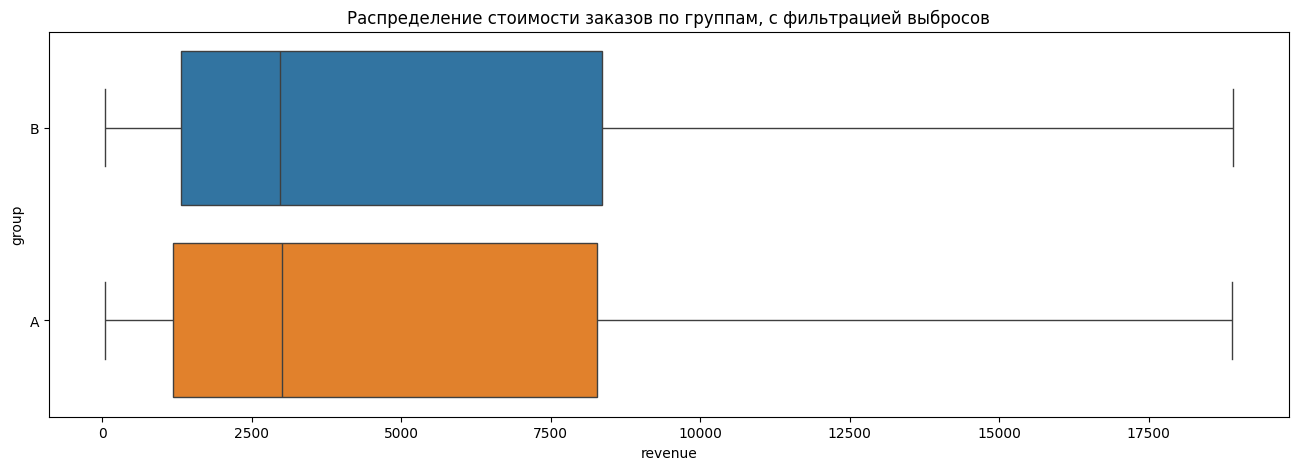

In [7]:
plt.figure(figsize=(16, 5))
plt.title('Распределение стоимости заказов по группам, без фильтрации выбросов')
sns.boxplot(data=orders, x='revenue', y='group', hue='group')
plt.show()
plt.figure(figsize=(16, 5))
plt.title('Распределение стоимости заказов по группам, с фильтрацией выбросов')
sns.boxplot(data=orders, x='revenue', y='group', showfliers=False, hue='group')
plt.show()

В группе **B** имеются 2 аномальных заказа, в остальном разделение по группам выглядит очень схожим.

**Изучим полученный файл `visitors`**


Data sample, size: 15


,date,group,visitors
31,2019-08-01,B,713
48,2019-08-18,B,737
33,2019-08-03,B,509
9,2019-08-10,A,406
22,2019-08-23,A,468
3,2019-08-04,A,717
8,2019-08-09,A,617
6,2019-08-07,A,644
34,2019-08-04,B,770
17,2019-08-18,A,668



Data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None


Display columns with missing data (as a proportion)



Series([], dtype: float64)


Data describe


,date,group,visitors
count,62,62,62.000000
unique,31,2,NaN
top,2019-08-01,A,NaN
freq,2,31,NaN
mean,NaN,NaN,607.290323
std,NaN,NaN,114.400560
min,NaN,NaN,361.000000
25%,NaN,NaN,534.000000
50%,NaN,NaN,624.500000
75%,NaN,NaN,710.500000



Check the number of full duplicate row


0


Display common hist


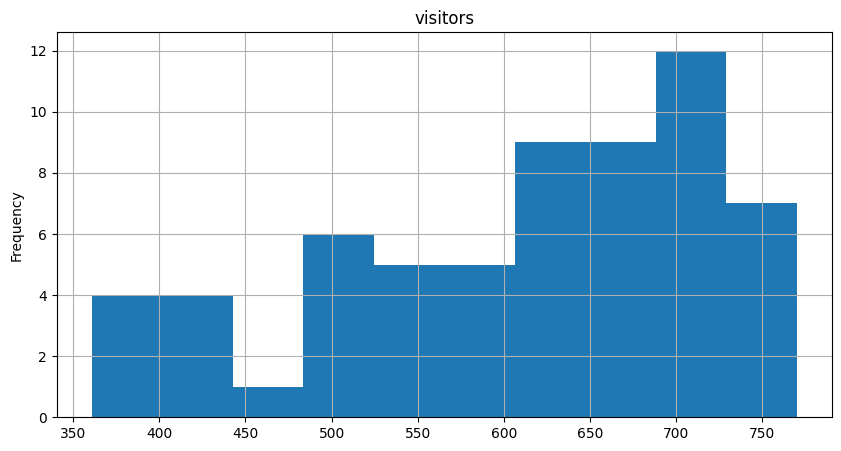

In [8]:
data_research(visitors)

<Axes: title={'center': 'Распределение количество посетителей по группам, без фильтрации выбросов'}, xlabel='visitors', ylabel='group'>

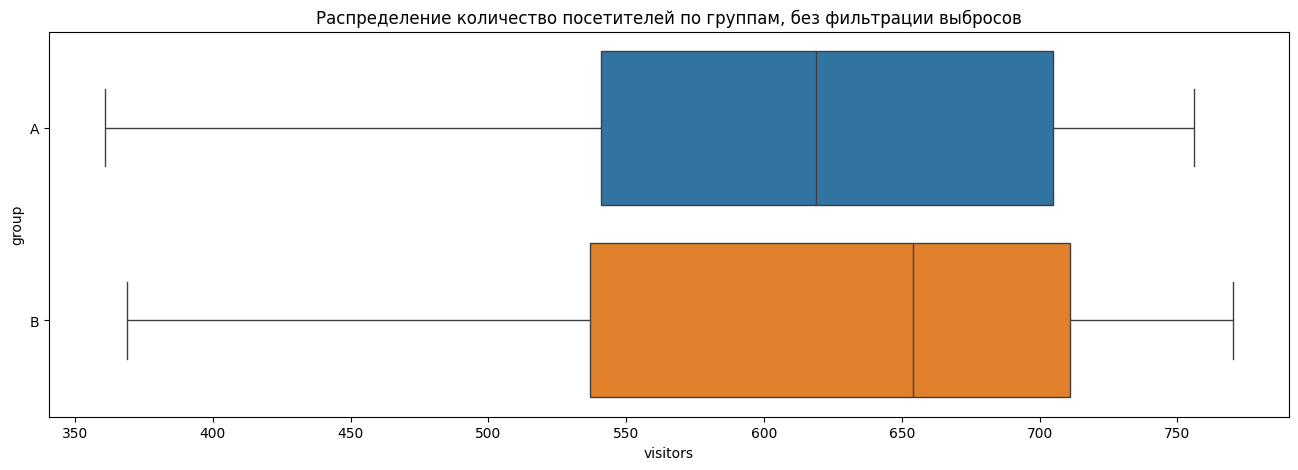

In [9]:
plt.figure(figsize=(16, 5))
plt.title('Распределение количество посетителей по группам, без фильтрации выбросов')
sns.boxplot(data=visitors, x='visitors', y='group', hue='group')
#plt.show()

Посмотрим на график посещения пользователей в разрезе групп.

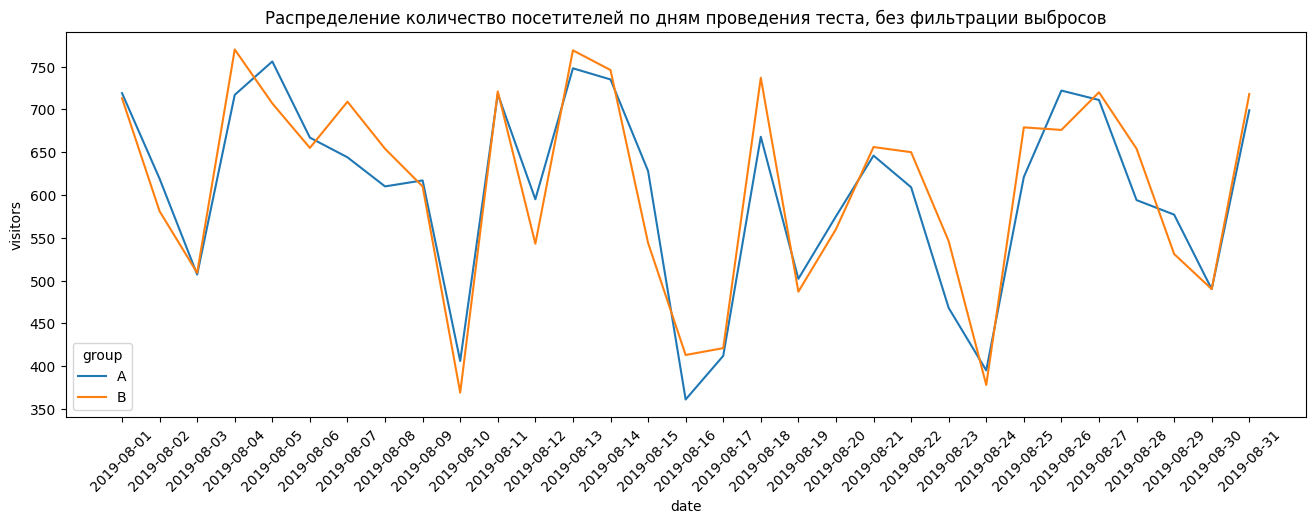

In [10]:
plt.figure(figsize=(16, 5))
plt.title('Распределение количество посетителей по дням проведения теста, без фильтрации выбросов')
sns.lineplot(data=visitors, x='date', y='visitors', hue='group')
plt.xticks(rotation=45)
plt.show()

Структура файла:

1. date — дата;
2. group — группа A/B-теста;
3. visitors — количество пользователей в указанную дату в указанной группе A/B-теста

За время проведения A/B теста не было выявлено аномальных данных по количеству посетителей сайта в сравнении двух групп. Посещение пользователей в двух группах во времени схоже.

**На основании изученных данных приведем небольшую предобработку**

В датафрейме `orders`
1. Приведем столбец с датой к формату даты
2. Переименуем столбец transactionId в transaction_id, а visitorId в visitor_id

В датафрейме `hypothesis`
1. Приведем название столбцов к нижнему регистру, и заменим пробелы на знак подчеркивания
2. Каждой гипотезе присвоим свой номер

Датафрейм `visitors`
1. Приведем столбец с датой к формату даты

In [11]:
orders['date'] = pd.to_datetime(orders['date'], errors = 'coerce')
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'})

In [12]:
hypothesis.columns = hypothesis.columns.str.lower().str.replace(' ', '_')
hypothesis['hyp_number'] = range(len(hypothesis))

In [13]:
visitors['date'] = pd.to_datetime(visitors['date'], errors = 'coerce')

**Проверим попадание одних и тех же пользователей в обе группы тестирования**

In [14]:
#сохраним исходный размер файла orders
order_size = orders.shape[0]

In [15]:
double_visitor_id = orders.groupby('visitor_id', as_index=False).agg(
    {'group': 'nunique', 'revenue': 'sum', 'transaction_id': 'nunique'}).query('group > 1')

In [16]:
double_visitor_id.head()

,visitor_id,group,revenue,transaction_id
2,8300375,2,12300,2
44,199603092,2,23180,5
51,232979603,2,2700,2
55,237748145,2,10810,5
66,276558944,2,17400,2


Рассчитаем размер суммы выручки задвоеных пользователей от общей стоимости всей выручки

In [17]:
"{0:.2%}".format(double_visitor_id['revenue'].sum() / orders['revenue'].sum())

'15.60%'

Рассчитаем процентное количество задвоеных пользователей от общего количества всех пользователей совершивших заказ

In [18]:
"{0:.2%}".format(double_visitor_id['visitor_id'].nunique() / orders['visitor_id'].nunique())

'5.63%'

Сохраним исходный датафрейм по заказам

In [19]:
orders_original = orders

В связи с внесением двойственности в тест, исключим пользователей которые попали в обе группы из датафрейма с заказами.

In [20]:
orders = orders.query('~(visitor_id.isin(@double_visitor_id["visitor_id"]))')

In [21]:
print('Размер обработанного датафрейма относительно исходного =', orders.shape[0] / order_size)

Размер обработанного датафрейма относительно исходного = 0.8487886382623224


## Приоритизация гипотез.


Добавим 2 столбца (`ICE` и `RICE`) содержащих рассчетную оценку для каждой каждой гипотезы

In [22]:
hypothesis['ice'] = (hypothesis.impact * hypothesis.confidence) / hypothesis.efforts
hypothesis['rice'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence) / hypothesis.efforts

Для построения графика рассчитаем сумму всех оценок по каждому столбцу

In [23]:
ice = hypothesis['ice'].sum()
rice = hypothesis['rice'].sum()

Добавим столбцы для отображения веса каждой гипотезы в процентах, так же добавим столбец с указанием ранга для каждого метода (ранг основывается на оценках каждого метода)

In [24]:
hypothesis['rice_pct'] = hypothesis['rice'] / rice * 100
hypothesis['ice_pct'] = hypothesis['ice'] / ice * 100
hypothesis['ice_rank'] = hypothesis['ice'].rank(method='dense', ascending=False).astype('int')
hypothesis['rice_rank'] = hypothesis['rice'].rank(method='dense', ascending=False).astype('int')

Создадим таблицу для построение столбчатого графика по полученным данным. Построение графика будет базироваться на весе каждой гипотезы переведенной в проценты

In [25]:
hyp = hypothesis.set_index(['hypothesis', 'hyp_number']).stack().reset_index().query('level_2 in ["ice_pct", "rice_pct"]')
hyp.columns=['hypothesis', 'hyp_number', 'scoring', 'ratio']

In [26]:
hyp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18 entries, 6 to 87
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   hypothesis  18 non-null     object 
 1   hyp_number  18 non-null     int64  
 2   scoring     18 non-null     object 
 3   ratio       18 non-null     float64
dtypes: float64(1), int64(1), object(2)
memory usage: 720.0+ bytes


Построим столбчтаный график по оценкам RICE и ICE, так же выведем таблицу с данными

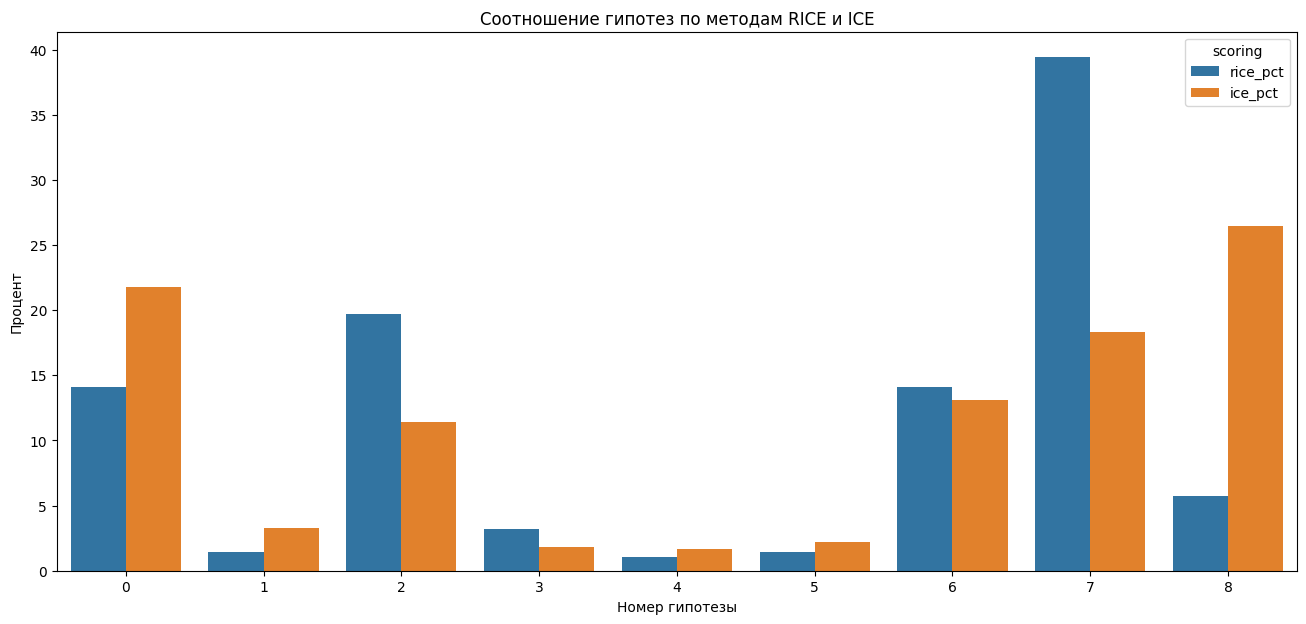

In [27]:
plt.figure(figsize=(16,7))
sns.barplot(data = hyp, x='hyp_number', y='ratio', hue='scoring')
plt.title('Соотношение гипотез по методам RICE и ICE')
plt.xlabel('Номер гипотезы')
plt.ylabel('Процент')
plt.show()

In [28]:
print('Сортировка по методике RICE от более важной к менее важной гипотезе')
display(
    hypothesis[['hyp_number', 'hypothesis', 'ice', 'rice', 'ice_rank', 'rice_rank']]
    .sort_values(by='rice', ascending=False).style.hide(axis="index")
)

print('Сортировка по методике ICE от более важной к менее важной гипотезе')
display(
    hypothesis[['hyp_number', 'hypothesis', 'ice', 'rice', 'ice_rank', 'rice_rank']]
    .sort_values(by='ice', ascending=False).style.hide(axis="index")
)

Сортировка по методике RICE от более важной к менее важной гипотезе


hyp_number,hypothesis,ice,rice,ice_rank,rice_rank
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000,3,1
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000,5,2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000,4,3
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000,1,4
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000,8,5
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000,6,6
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000,7,6
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000,9,7


Сортировка по методике ICE от более важной к менее важной гипотезе


hyp_number,hypothesis,ice,rice,ice_rank,rice_rank
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,16.200000,1,4
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,40.000000,2,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,112.000000,3,1
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,40.000000,4,3
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,56.000000,5,2
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,4.000000,6,6
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,4.000000,7,6
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,9.000000,8,5
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,3.000000,9,7


**ВЫВОД**

При учете охвата (reach) почти у всех гипотез изменился ранг, так у гипотеза №8 набрала макимальную оценку по метдоу ICE, а при расчете оценки методом RICE эта гипотеза стала 4.

Первую тройку по методике RICE составляют гипотезы №№:
1. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок	(по ICE ранг равен 3)
2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа (по ICE ранг равен 5)
3. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (по ICE ранг равен 2)

Первая тройка по методике ICE составляют гипотезы №№:
1. Запустить акцию, дающую скидку на товар в день рождения (по RICE ранг равен 4)
2. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей (по RICE ранг равен 3)
3. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (по RICE ранг равен 1)

В связи с чем можно сделать вывод, что при учете охвата ситуация по приоретизации может в корне изменить ситуацию.

## Анализ A/B-теста

### Проведем небольшое исследование и обработку файла с заказами

Проверим по обеим группам, что во все даты, когда были посещения совершались покупки. 

- Значение `0` - говорит о положительном результате проверки
- Иные значения - показывают количество дней, когда были посещения но не совершались покупки

In [29]:
print('По группе A разница составляет - ', sum(1- (orders['date'].drop_duplicates().sort_values().reset_index(drop=True) == 
         visitors.query('group == "A"')['date'].drop_duplicates().sort_values().reset_index(drop=True)).astype('int')))

По группе A разница составляет -  0


In [30]:
print('По группе B разница составляет - ', sum(1- (orders['date'].drop_duplicates().sort_values().reset_index(drop=True) == 
         visitors.query('group == "B"')['date'].drop_duplicates().sort_values().reset_index(drop=True)).astype('int')))

По группе B разница составляет -  0


Создадим переменную содержащую все комбинации дат заказов и групп тестировани.

In [31]:
dates_groups = orders[['date', 'group']].drop_duplicates()

Сгруппируем накопительно данные по количеству заказов, выручке, посетителей, покупателей в разрезе дней

In [32]:
# Сгруппируем накопительно данные по заказам
ordersAggregated = dates_groups.apply(
    lambda x: orders[
        np.logical_and(orders['date'] <= x['date'],
                       orders['group'] == x['group'])
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [33]:
#Сгруппируем накопительно данные по количеству посещений
visitorsAggregated = dates_groups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

In [34]:
#Объеденим две сгруппированные таблицы по составному ключу ('date' и 'group')
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

In [35]:
ordersAggregated

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


In [36]:
visitorsAggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


In [37]:
cumulativeData

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


Посмотрим совпадают ли даты начала и окончания теста в полученных сгруппированных данных, а так же проверим, что эти даты совпадают с датами из исходного файла с заказами

In [38]:
display(
    'Крайние даты из сгруппированных данных, в разрезе групп',
    cumulativeData.groupby('group').agg({'date': ['max','min']})
)
print()
display('Крайние даты из исходных данных',orders.agg({'date': ['max', 'min']}))

'Крайние даты из сгруппированных данных, в разрезе групп'

date           
             max        min
group                      
A     2019-08-31 2019-08-01
B     2019-08-31 2019-08-01

'Крайние даты из исходных данных'

,date
max,2019-08-31
min,2019-08-01


Все даты между собой совпадают, что говорит, что начало и окочание теста было синхронизировано между группами

In [39]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeIndicatorsA = cumulativeData.query('group == "A"')[['date','revenue', 'orders', 'buyers', 'visitors']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeIndicatorsB = cumulativeData.query('group == "B"')[['date','revenue', 'orders', 'buyers', 'visitors']]

### Построим кумулятивный график по выручке

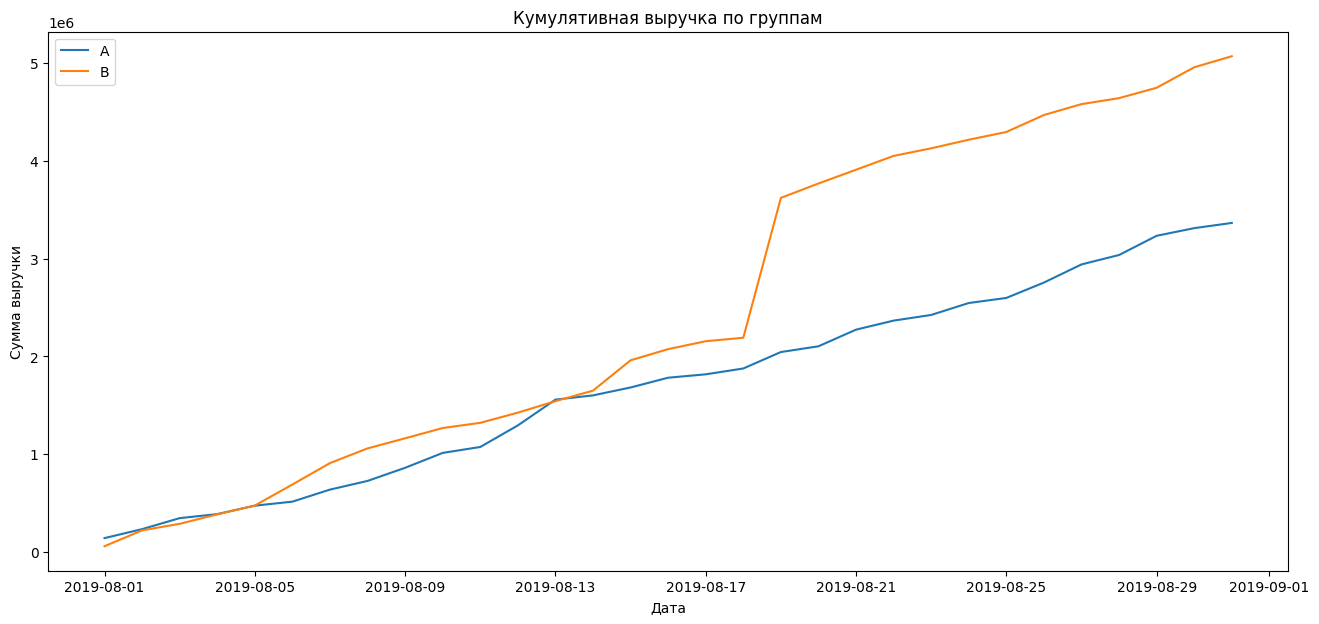

In [40]:
plt.figure(figsize=(16,7))
plt.plot(cumulativeIndicatorsA['date'], cumulativeIndicatorsA['revenue'], label='A')
plt.plot(cumulativeIndicatorsB['date'], cumulativeIndicatorsB['revenue'], label='B')
plt.title('Кумулятивная выручка по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма выручки')
plt.legend()
plt.show()

На приведенном графике, до середины августа, группа B выглядит лучше группы A по кумулятивной выручке, рост выручки в данный период у двух графиков выглядит схоже. В середине августа есть резкое увеличение выручки у группы B, при том, что группа А сохраняет планомерный рост. 

Причин такого скачка у группы B может быть несколько:
1. Ранее, в предобработки данных мы уже видили в группе B один аномально дорогой заказ, возможно именно он обуславливает такое поведение графика
2. В день, когда произошел резкий скачок было аномально большое количество заказов в группе B, что привело к такому поведению графика.
3. Обе выше описанные причины могли иметь место, и сумма этих событий могла дать такой результат

Данные предположения мы рассмотрим далее по ходу исследования

### Построим график кумулятивного количества заказов по группам.

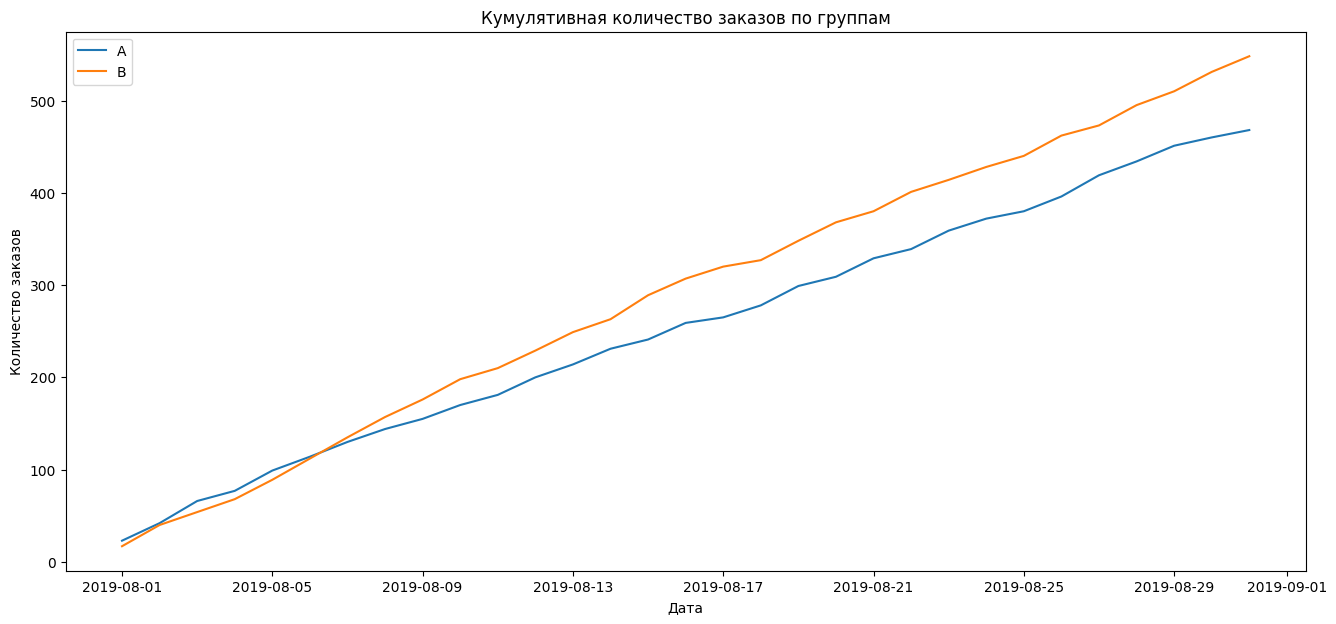

In [41]:
plt.figure(figsize=(16,7))
plt.plot(cumulativeIndicatorsA['date'], cumulativeIndicatorsA['orders'], label='A')
plt.plot(cumulativeIndicatorsB['date'], cumulativeIndicatorsB['orders'], label='B')
plt.title('Кумулятивная количество заказов по группам')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

Группа B накопительно увеличивает разрыв по количеству заказов относительно группы А, резкое увеличение количество заказов отсутствует.

### Построим график среднего чека

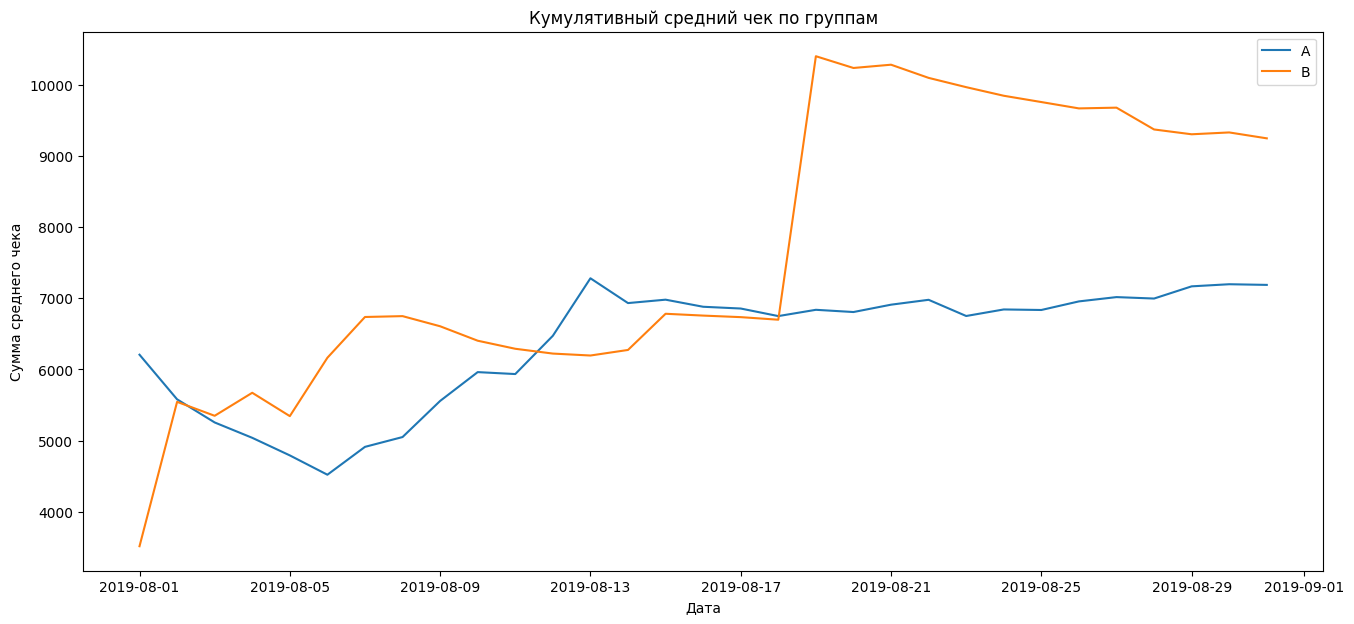

In [42]:
plt.figure(figsize=(16,7))
plt.plot(cumulativeIndicatorsA['date'], cumulativeIndicatorsA['revenue'] / cumulativeIndicatorsA['orders'], label='A')
plt.plot(cumulativeIndicatorsB['date'], cumulativeIndicatorsB['revenue'] / cumulativeIndicatorsB['orders'], label='B')
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')
plt.legend()
plt.show()

График по среднему чеку подтверждает ранее увиденную аномалию в середине августа из за которой, график становится не информативным после данной аномалии. В первые две недели мы видим, до возникнования аномалии, мы видим, что лидерство одной группы сменялось другой.

### Построим график относительного изменения кумулятивного среднего чека группы B к группе A. 

In [43]:
mergedCumulativeIndicators = cumulativeIndicatorsA.merge(
    cumulativeIndicatorsB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']
)

In [44]:
mergedCumulativeIndicators.head()

,date,revenueA,ordersA,buyersA,visitorsA,revenueB,ordersB,buyersB,visitorsB
0,2019-08-01,142779,23,19,719,59758,17,17,713
1,2019-08-02,234381,42,36,1338,221801,40,39,1294
2,2019-08-03,346854,66,60,1845,288850,54,53,1803
3,2019-08-04,388030,77,71,2562,385740,68,66,2573
4,2019-08-05,474413,99,92,3318,475648,89,87,3280


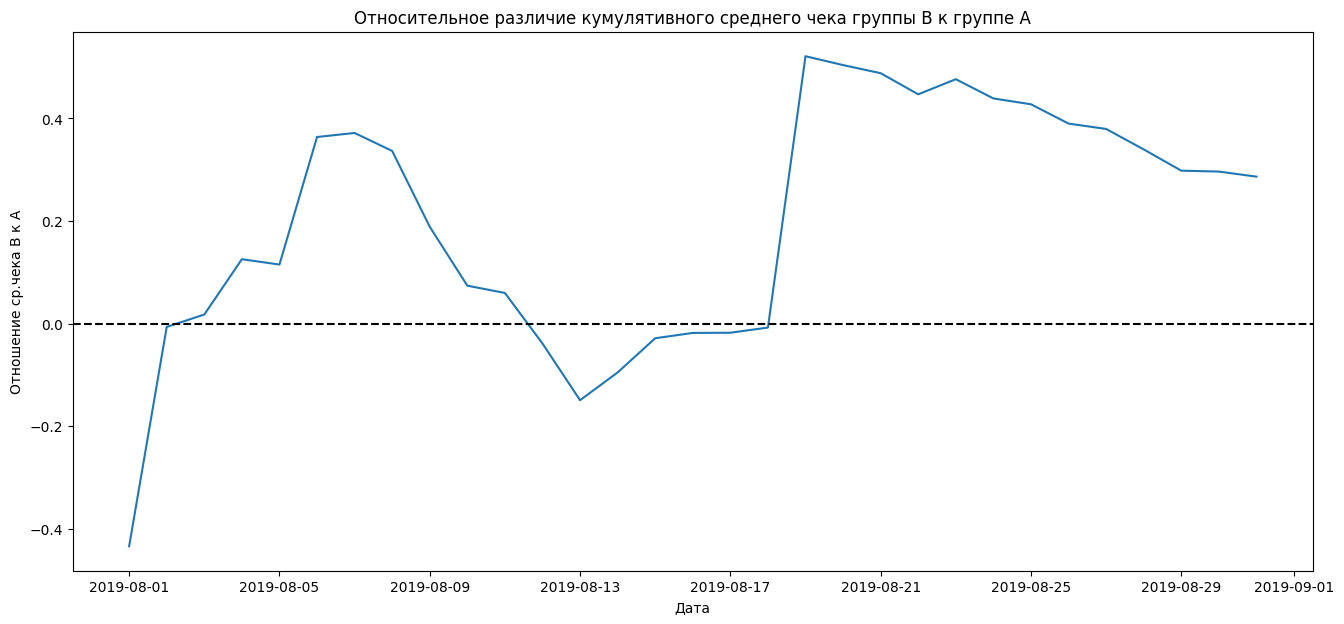

In [45]:
plt.figure(figsize=(16,7))
plt.plot(mergedCumulativeIndicators['date'], (mergedCumulativeIndicators['revenueB']/mergedCumulativeIndicators['ordersB'])/(mergedCumulativeIndicators['revenueA']/mergedCumulativeIndicators['ordersA'])-1)
plt.title('Относительное различие кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение ср.чека B к A')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

Начало графика показывает скачкообразную кривую, но по мере накопления средний чек начинал выравниваться в сравнении с группой A, но с учетом ранее проанализированных данных, аномальные заказы похоже внесли сильную погрешность, так как после резкого скачка, когда группа B превосходила группу A на 40%, кривая снова пошла вниз. Можно предположить, что без учета аномалий средний чек двух групп более менее одинаков.

### График среднего количества заказа на посетителя

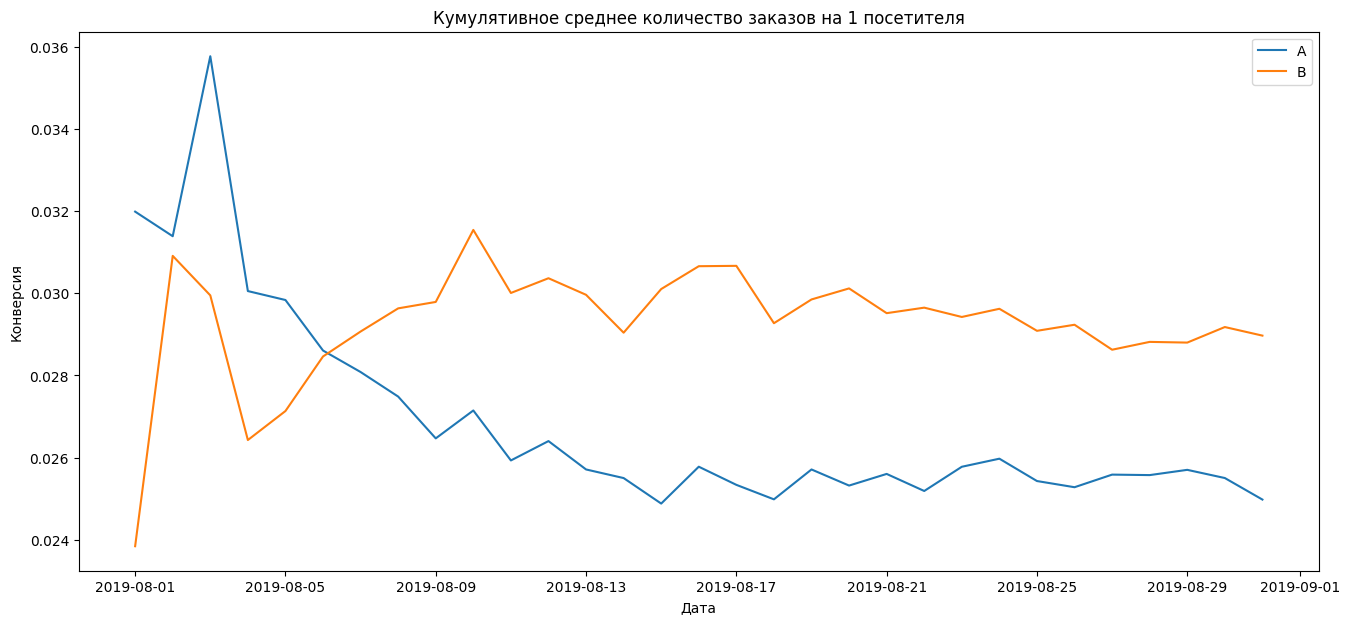

In [46]:
plt.figure(figsize=(16,7))
plt.plot(cumulativeIndicatorsA['date'], cumulativeIndicatorsA['orders'] / cumulativeIndicatorsA['visitors'], label='A')
plt.plot(cumulativeIndicatorsB['date'], cumulativeIndicatorsB['orders'] / cumulativeIndicatorsB['visitors'], label='B')
plt.title('Кумулятивное среднее количество заказов на 1 посетителя')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.legend()
plt.show()

А вот по количеству заказов накопительно группа B превосходит группу A, что при сохранении среднего чека на одинаковом уровне дает необходимый результат (увеличение средней выручки)

### Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

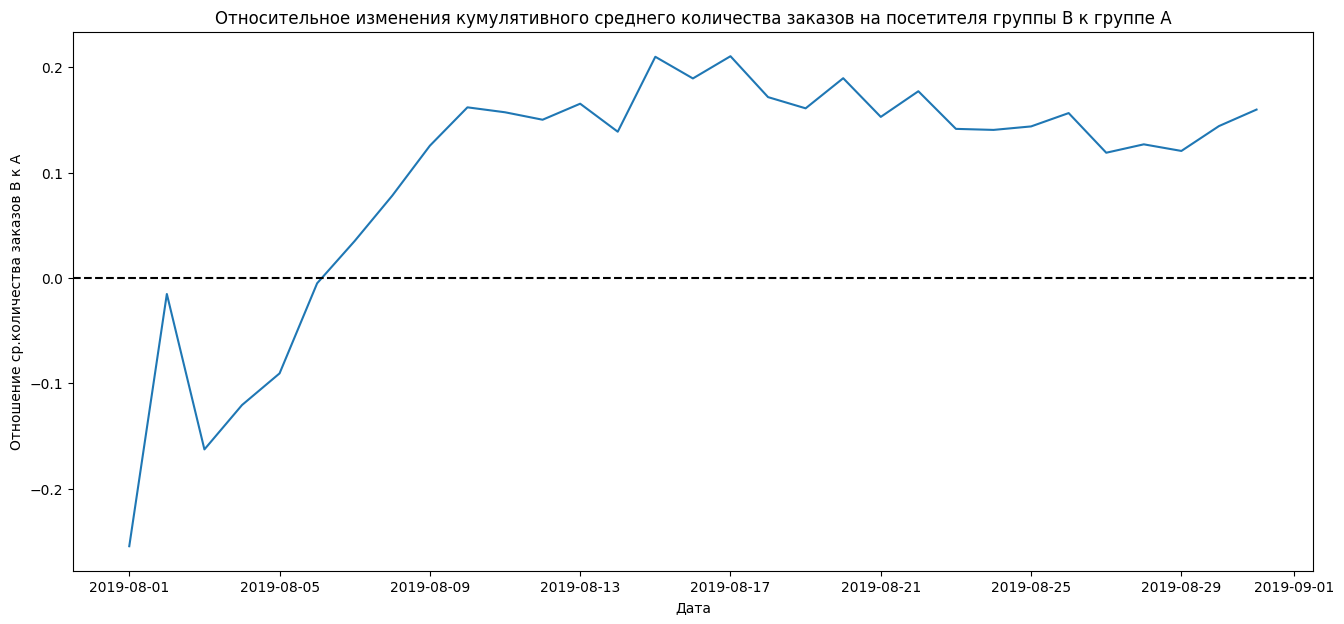

In [47]:
plt.figure(figsize=(16,7))
plt.plot(mergedCumulativeIndicators['date'], (mergedCumulativeIndicators['ordersB']/mergedCumulativeIndicators['visitorsB'])/(mergedCumulativeIndicators['ordersA']/mergedCumulativeIndicators['visitorsA'])-1)
plt.title('Относительное изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Отношение ср.количества заказов B к A')
plt.axhline(y=0, color='black', linestyle='--') 
plt.show()

После первой недели, группа B начала опережать группу A по количеству заказов, на последний день теста количество заказов в группе B больше на 15% чем в группе A

### Построим точечный график количества заказов на пользователя

Создадим переменную содержащию количество заказов соответствующих каждому уникальному id покупателю.

In [48]:
ordersByVisitors = orders.groupby('visitor_id')['transaction_id'] \
                   .nunique().reset_index().rename(columns={'transaction_id': 'orders_cnt'})

In [49]:
ordersByVisitors.head()

,visitor_id,orders_cnt
0,5114589,1
1,6958315,1
2,11685486,1
3,39475350,1
4,47206413,1


Определим 90, 95 и 99 перцентили для количества заказов

In [50]:
np.percentile(ordersByVisitors['orders_cnt'], [90, 95, 99])

array([1., 1., 2.])

Присвоим верхнюю границу равную 99 перцентилю, сверх которых идут аномально большое количество заказов

In [51]:
many_orders = np.percentile(ordersByVisitors['orders_cnt'], 99)

Построим график

In [52]:
x_values = range(len(ordersByVisitors))

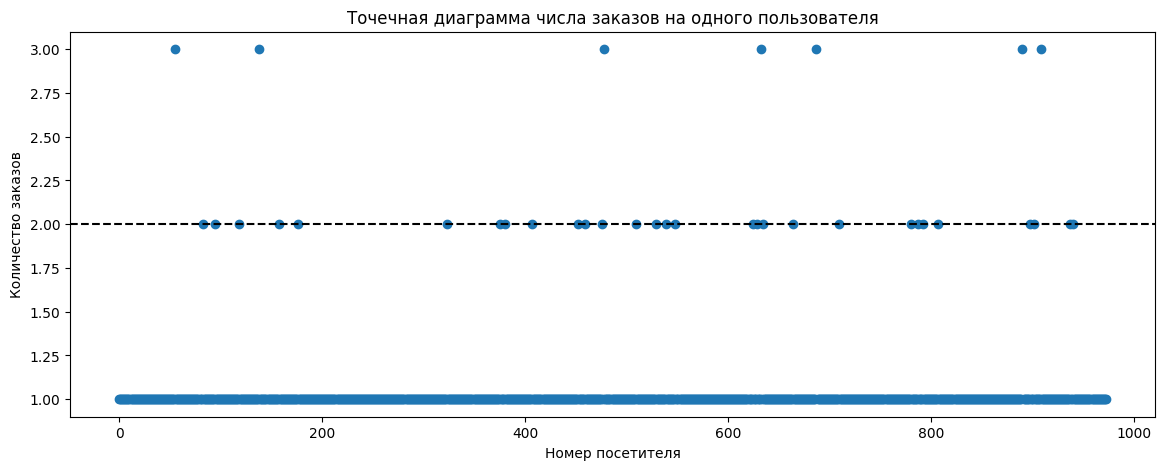

In [53]:
plt.figure(figsize=(14,5))
plt.scatter(x_values, ordersByVisitors['orders_cnt'])
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.xlabel('Номер посетителя')
plt.ylabel('Количество заказов')
plt.axhline(y=many_orders, color='black', linestyle='--') 
plt.show()

График подтверждает, что ранее установленная граница в 2+ заказа является корректной

### Построим точечный график стоимостей заказов

Определим 90, 95 и 99 перцентили для стоимости 1 заказа

In [54]:
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

Присвоим верхнюю границу равную 99 перцентилю, сверх которых идут аномально дорогие заказы

In [55]:
expensive_orders = np.percentile(orders['revenue'], 99)

Построим график

In [56]:
x_values = range(len(orders))

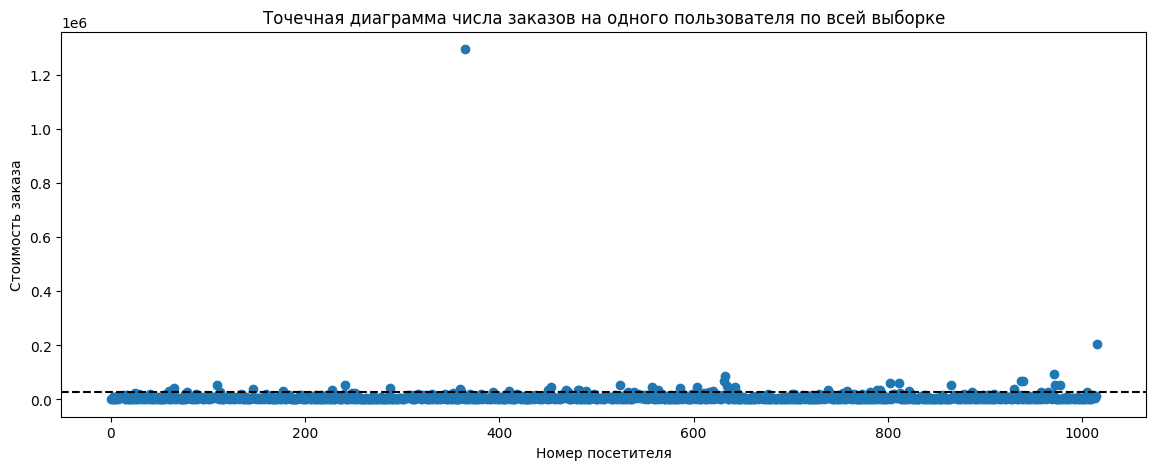

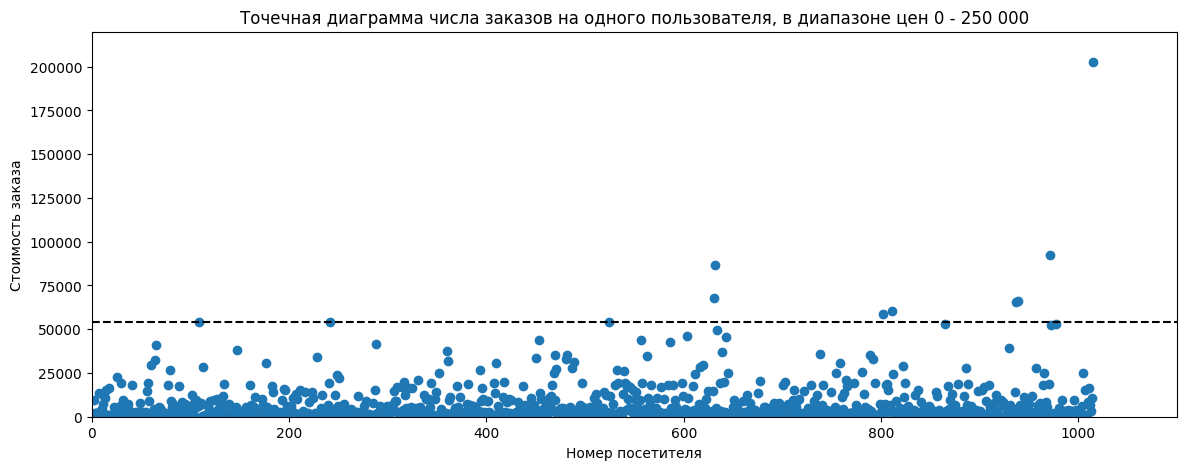

In [57]:
plt.figure(figsize=(14,5))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма числа заказов на одного пользователя по всей выборке')
plt.xlabel('Номер посетителя')
plt.ylabel('Стоимость заказа')
plt.axhline(y=28000, color='black', linestyle='--') 
plt.show()

plt.figure(figsize=(14,5))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма числа заказов на одного пользователя, в диапазоне цен 0 - 250 000')
plt.xlabel('Номер посетителя')
plt.ylabel('Стоимость заказа')
plt.axhline(y=expensive_orders, color='black', linestyle='--') 
plt.axis([0, 1100, 0, 220000])
plt.show()

График подтверждает, что ранее установленная граница по стоимости в размере 53904 за 1 заказ является корректной

### Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.

Создадим две переменные (по 1 на группу), содержащие id покупателей и количество заказов им совершенных

In [58]:
ordersByVisitorsA = orders.query('group == "A"').groupby('visitor_id', as_index=False)['transaction_id'].nunique()
ordersByVisitorsA.columns = ['visitor_id', 'orders_cnt']
ordersByVisitorsB = orders.query('group == "B"').groupby('visitor_id', as_index=False)['transaction_id'].nunique()
ordersByVisitorsB.columns = ['visitor_id', 'orders_cnt']

Сформируем еще 2 переменные, где каждый элемент — число заказов определённого пользователя, в том числе включим пользователей с количеством заказов равное нулю. Переменные формируются по не очищенным данным

In [59]:
sampleA = pd.concat(
    [
        ordersByVisitorsA['orders_cnt'],
        pd.Series(0, index=np.arange(visitors.query('group == "A"')['visitors'].sum() - len(ordersByVisitorsA['orders_cnt'])), name='orders')
    ],axis=0
).reset_index(drop=True)

sampleB = pd.concat(
    [
        ordersByVisitorsB['orders_cnt'],
        pd.Series(0, index=np.arange(visitors.query('group == "B"')['visitors'].sum() - len(ordersByVisitorsA['orders_cnt'])), name='orders')
    ],axis=0
).reset_index(drop=True)

Сформулируем две гипотезы:
- H0 - среднее количество заказов по группам одинаково
- H1 - имеются различия в среднем количестве заказов между группами

Зададим уровень статистической значимости равной 0.05

In [60]:
alpha = .05
order_pvalue = st.mannwhitneyu(sampleA, sampleB)[1]

In [61]:
if order_pvalue < alpha:
    print('По неочищенным данным конверсия групп A и B не одинакова (статистически значима)\n')
else:
    print('По неочищенным данным конверсия групп A и B одинакова (статистически не значима)\n')
print('Уровень статистической значимости = ', alpha)
print('P-value =',"{0:.5f}".format(order_pvalue))
print('Прирост в количестве заказов группы B к A составляет',"{0:.3%}".format(sampleB.mean() / sampleA.mean() - 1))

По неочищенным данным конверсия групп A и B не одинакова (статистически значима)

Уровень статистической значимости =  0.05
P-value = 0.01340
Прирост в количестве заказов группы B к A составляет 15.473%


### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

Посмотрим на распределение.

<Axes: >

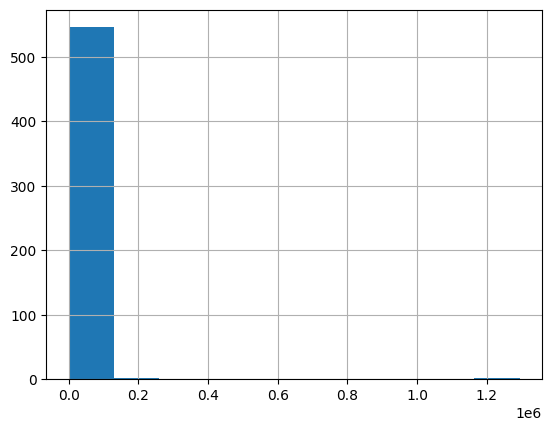

In [62]:
orders.query('group == "B"')['revenue'].hist()

<Axes: >

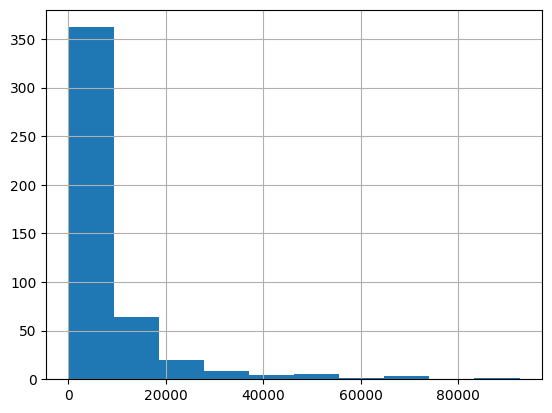

In [63]:
orders.query('group == "A"')['revenue'].hist()

Видим скошенное вправо распределение у двух групп, к тому же есть сильные выбросы у группы B

Сформулируем две гипотезы:

- H0 - средняя стоимость заказа по группам одинакова
- H1 - имеются различия в средней стоимости заказов между группами

Зададим уровень статистической значимости равной 0.05

In [64]:
alpha = .05
revenue_pvalue = st.mannwhitneyu(orders.query('group == "A"')['revenue'], orders.query('group == "B"')['revenue'])[1]

In [65]:
if revenue_pvalue < alpha:
    print('По неочищенным данным средняя стоимость заказа между групп A и B не одинакова (статистически значима)\n')
else:
    print('По неочищенным данным средняя стоимость заказа между групп A и B одинакова (статистически не значима)\n')

print('Уровень статистической значимости = ', alpha)
print('P-value =','{0:.3f}'.format(revenue_pvalue))
print(
    'Прирост в средней стоимости заказа группы B к A составляет',
    '{0:.3%}'.format(
        orders.query('group == "B"')['revenue'].mean() / 
        orders.query('group == "A"')['revenue'].mean() - 1
    )
) 

По неочищенным данным средняя стоимость заказа между групп A и B одинакова (статистически не значима)

Уровень статистической значимости =  0.05
P-value = 0.829
Прирост в средней стоимости заказа группы B к A составляет 28.660%


Несмотря на большой прирост в средней стоимости за заказ, в среднем стоимость заказа между группами одинакова. Прирост в среднем вызван наличием аномалей в группе B

### Посчитать статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

Создим базу id с исключаемыми посетителями (где слишком большая сумма заказа или слишком много заказов)

In [66]:
abnormal_orders = ordersByVisitors.query('orders_cnt > @many_orders')['visitor_id']
abnormal_revenue = orders.query('revenue > @expensive_orders')['visitor_id']
abnormal_visitor_id = pd.concat([abnormal_orders, abnormal_revenue], axis=0).reset_index(drop=True)

Сформируем 2 переменные, где каждый элемент — число заказов определённого пользователя, в том числе включим пользователей с количеством заказов равное нулю. Переменные формируются по очищенным данным

In [67]:
sampleAFiltered = pd.concat(
    [
        ordersByVisitorsA.query('~visitor_id.isin(@abnormal_visitor_id)')['orders_cnt'],
        pd.Series(0, index=np.arange(visitors.query('group == "A"')['visitors'].sum() - len(ordersByVisitorsA)), name='orders')
    ],axis=0
)

sampleBFiltered = pd.concat(
    [
        ordersByVisitorsB.query('~visitor_id.isin(@abnormal_visitor_id)')['orders_cnt'],
        pd.Series(0, index=np.arange(visitors.query('group == "B"')['visitors'].sum() - len(ordersByVisitorsB)), name='orders')
    ],axis=0
)

Сформулируем две гипотезы:

- H0 - среднее количество заказов по группам одинаково
- H1 - имеются различия в среднем количестве заказов между группами

Зададим уровень статистической значимости равной 0.05

In [68]:
alpha = .05
clean_order_pvalue = st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

In [69]:
if clean_order_pvalue < alpha:
    print('По очищенным данным конверсия групп A и B не одинакова (статистически значима)\n')
else:
    print('По очищенным данным конверсия групп A и B одинакова (статистически не значима)\n')
print('Уровень статистической значимости = ', alpha)
print('P-value =',"{0:.5f}".format(clean_order_pvalue))
print(
    'Прирост в количестве заказов группы B к A составляет',
    "{0:.3%}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1)
)

По очищенным данным конверсия групп A и B не одинакова (статистически значима)

Уровень статистической значимости =  0.05
P-value = 0.00702
Прирост в количестве заказов группы B к A составляет 18.921%


### Посчитать статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Сформулируем две гипотезы:

- H0 - средняя стоимость заказа по группам одинакова
- H1 - имеются различия в средней стоимости заказов между группами

Зададим уровень статистической значимости равной 0.05

In [70]:
alpha = .05
clean_revenue_pvalue = st.mannwhitneyu(orders.query('group == "A" & ~(visitor_id.isin(@abnormal_visitor_id))')[
                                       'revenue'], orders.query('group == "B" & ~(visitor_id.isin(@abnormal_visitor_id))')['revenue'])[1]

In [71]:
if clean_revenue_pvalue < alpha:
    print('По очищенным данным средняя стоимость заказа между групп A и B не одинакова (статистически значима)\n')
else:
    print('По очищенным данным средняя стоимость заказа между групп A и B одинакова (статистически не значима)\n')

print('Уровень статистической значимости = ', alpha)
print('P-value =','{0:.3f}'.format(clean_revenue_pvalue))
print(
    'Прирост в средней стоимости заказа группы B к A составляет',
    '{0:.3%}'.format(
        orders.query('group == "B" & ~(visitor_id.isin(@abnormal_visitor_id))')['revenue'].mean() /
        orders.query('group == "A" & ~(visitor_id.isin(@abnormal_visitor_id))')['revenue'].mean() - 1
                    )
) 

По очищенным данным средняя стоимость заказа между групп A и B одинакова (статистически не значима)

Уровень статистической значимости =  0.05
P-value = 0.788
Прирост в средней стоимости заказа группы B к A составляет -3.234%


По очищенным данным статистика нам говорит, что стоимость заказа все таки одинакова, но вот средняя стоимость заказа группы B к группе A упала на 3.234%

## ВЫВОД

На протяжении анализа A/B теста тестовая группа B практически всегда выглядела лучше, чем группа A.

Так, например по грязным данным со временем увеличивался отрыв у группы B по отношению к группе A по кумулятивной выручке и кумулятивному количеству заказов,. Касаемо кумулятивного среднего чека, на графике видна аномалия в середине августа, когда рост среднего чека у группы B резко вырос по отношению к группе А, у группы А к тому моменту уже началась стабилизации стоимости среднего чека. Разрыв, в пользу группы B в части количество заказов на одного пользователя после 1 декады теста стабилизировался, тем самым показывая, что группа B показала прирост конверсии.

Применяя статистический критерий Манна-Уитни вначале к грязным данным, потом к очищенным данным (где убраны пользователи с аномально дорогими заказами, и пользователи с аномально большим количеством заказов), были получены следующие данные:

1. По неочищенным данным конверсия групп A и B не одинакова, прирост в количестве заказов группы B к A составляет 15.473%
2. По очищенным данным конверсия групп A и B не одинакова, прирост в количестве заказов группы B к A составляет 18.921%
3. По неочищенным данным средняя стоимость заказа между групп A и B одинакова, прирост в средней стоимости заказа группы B к A составляет 28.660% (имеются одиночные сверх дорогие заказы, это объясняет прирост стоимости)
4. По очищенным данным средняя стоимость заказа между групп A и B одинакова, прирост в средней стоимости заказа группы B к A составляет -3.234%

В связи с чем мы можем утверждать, что средняя стоимость заказа не изменилась, но вот конверсия у группы B выше, чем у группы A, что в свою очередь ведет к увеличению общей выручки. На основании этого тест можно считать законченным и фиксировать победу группы B над группой A.
